In [ ]:
import argparse
import os
import math
from typing import Optional
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from tqdm import tqdm

In [ ]:
# ---------------------------
# Model components
# ---------------------------

class DepthwiseConv3x3(nn.Module):
    """Lightweight 3x3 Conv: Depthwise -> Pointwise"""
    def __init__(self, in_ch, out_ch=None):
        super().__init__()
        if out_ch is None: out_ch = in_ch
        self.dw = nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1, groups=in_ch, bias=False)
        self.pw = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = nn.GELU() # GELU is standard for Mixers (matches MLP)

    def forward(self, x):
        return self.act(self.norm(self.pw(self.dw(x))))

class PatchEmbedding(nn.Module):
    """Standard Patch Embedding (Linear Projection)"""
    def __init__(self, in_ch, patch_size, emb_dim):
        super().__init__()
        # This is the standard, lightweight Mixer embedding
        # Input: [B, 3, 32, 32] -> Conv(k=4, s=4) -> [B, 128, 8, 8]
        self.proj = nn.Conv2d(in_ch, emb_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x) # [B, C, H/p, W/p]
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, dropout=0.0):
        super().__init__()
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class MixerBlock(nn.Module):
    """One Mixer block: Token-mixing MLP then Channel-mixing MLP."""
    def __init__(self, num_patches, dim, token_mlp_dim, channel_mlp_dim, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.token_mlp = MLP(num_patches, token_mlp_dim, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.channel_mlp = MLP(dim, channel_mlp_dim, dropout)

    def forward(self, x):
        # x: B, N, C
        y = self.norm1(x)
        y = y.transpose(1, 2)         # B, C, N
        y = self.token_mlp(y)         # mixes tokens
        y = y.transpose(1, 2)         # B, N, C
        x = x + y
        y = self.norm2(x)
        y = self.channel_mlp(y)
        x = x + y
        return x

class HybridMixer(nn.Module):
    def __init__(self, *, image_size=32, patch_size=4, in_ch=3, emb_dim=128,
                 depth=8, token_mlp_dim=64, channel_mlp_dim=256, num_classes=10,
                 use_conv_stem=False, interleave_conv_every=0, dropout=0.0):
        super().__init__()

        # --- FIX: Ensure interleave_conv_every is an integer (defaults None to 0) ---
        interleave_conv_every = interleave_conv_every or 0
        # ----------------------------------------------------------------------------

        self.patch_size = patch_size
        self.emb_dim = emb_dim

        # 1. Standard Patch Embedding
        self.patch_embed = PatchEmbedding(in_ch, patch_size, emb_dim)

        # 2. OPTIONAL: "Post-Patching" Conv Stem
        self.use_conv_stem = use_conv_stem
        if use_conv_stem:
            self.stem_conv = DepthwiseConv3x3(emb_dim, emb_dim)

        self.num_patches = (image_size // patch_size) ** 2

        self.blocks = nn.ModuleList()
        for i in range(depth):
            self.blocks.append(MixerBlock(self.num_patches, emb_dim, token_mlp_dim, channel_mlp_dim, dropout))

            # OPTIONAL: Interleaved Conv
            # Now this is safe because interleave_conv_every is guaranteed to be an int (0 or higher)
            if interleave_conv_every > 0 and (i + 1) % interleave_conv_every == 0:
                self.blocks.append(DepthwiseConv3x3(emb_dim, emb_dim))

        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        # 1. Patch Embed -> [B, C, H_grid, W_grid]
        x = self.patch_embed(x)

        # 2. Apply Conv Stem on the grid (if enabled)
        if self.use_conv_stem:
            x = self.stem_conv(x)

        # 3. Flatten for Mixer: [B, C, H, W] -> [B, N, C]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)

        # 4. Process Blocks
        for blk in self.blocks:
            if isinstance(blk, MixerBlock):
                x = blk(x)
            else:
                # It's an interleaved Conv layer. Reshape to grid -> Conv -> Flatten
                Hn = Wn = int(math.sqrt(x.shape[1]))
                x_img = x.transpose(1, 2).reshape(B, C, Hn, Wn)
                x_img = blk(x_img)
                x = x_img.flatten(2).transpose(1, 2)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x


In [ ]:

# ---------------------------
# Training utilities
# ---------------------------

def get_dataloaders(dataset='cifar10', batch_size=128, num_workers=2, augment=True):
    # DEFINE TRANSFORMS FIRST (Fixes the NameError crash)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2470, 0.2435, 0.2616)

    # Base transforms
    train_transforms_list = [
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4),
        T.RandomRotation(15),
    ]

    if augment:
        train_transforms_list.append(T.ColorJitter(0.1, 0.1, 0.1, 0.02))

    train_transforms_list += [
        T.ToTensor(),
        T.Normalize(mean, std)
    ]

    if augment:
        train_transforms_list.append(T.RandomErasing(p=0.1))

    train_transform = T.Compose(train_transforms_list)
    test_transform = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

    # NOW INSTANTIATE DATASETS
    root = './data'
    if dataset.lower() == 'cifar10':
        train_ds = torchvision.datasets.CIFAR10(root, train=True, download=True, transform=train_transform)
        test_ds = torchvision.datasets.CIFAR10(root, train=False, download=True, transform=test_transform)
        num_classes = 10
    elif dataset.lower() == 'cifar100':
        train_ds = torchvision.datasets.CIFAR100(root, train=True, download=True, transform=train_transform)
        test_ds = torchvision.datasets.CIFAR100(root, train=False, download=True, transform=test_transform)
        num_classes = 100
    else:
        raise ValueError("Dataset not supported for this project script.")

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=True)

    return train_loader, test_loader, num_classes

def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k.mul_(100.0 / batch_size)).item())
        return res

def train_one_epoch(model, dataloader, optimizer, device, epoch, scheduler=None, print_freq=100):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, targets) in pbar:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        batch_size = images.size(0)
        acc1 = accuracy(outputs, targets, topk=(1,))[0]
        total_loss += loss.item() * batch_size
        total_acc += acc1 * batch_size / 100.0
        total_samples += batch_size
        if (i + 1) % print_freq == 0:
            pbar.set_description(f"Epoch {epoch} iter {i+1} loss {loss.item():.4f} acc {acc1:.2f}")
    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples * 100.0
    return avg_loss, avg_acc

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, targets)
            batch_size = images.size(0)
            acc1 = accuracy(outputs, targets, topk=(1,))[0]
            total_loss += loss.item() * batch_size
            total_acc += acc1 * batch_size / 100.0
            total_samples += batch_size
    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples * 100.0
    return avg_loss, avg_acc


In [ ]:
# ---------------------------
# Main: training script
# ---------------------------

def parse_args():
    p = argparse.ArgumentParser()
    p.add_argument('--dataset', type=str, default='cifar10', choices=['cifar10', 'cifar100'])
    p.add_argument('--batch-size', type=int, default=128)
    p.add_argument('--epochs', type=int, default=30)
    p.add_argument('--lr', type=float, default=3e-3)
    p.add_argument('--weight-decay', type=float, default=1e-4)
    p.add_argument('--patch-size', type=int, default=4)
    p.add_argument('--emb-dim', type=int, default=128)
    p.add_argument('--depth', type=int, default=8)
    p.add_argument('--token-mlp-dim', type=int, default=64)
    p.add_argument('--channel-mlp-dim', type=int, default=256)
    p.add_argument('--use-conv-stem', action='store_true')
    p.add_argument('--interleave-conv-every', type=int, default=0, help="insert conv after every K blocks if >0")
    p.add_argument('--dropout', type=float, default=0.0)
    p.add_argument('--no-augment', dest='augment', action='store_false')
    p.add_argument('--seed', type=int, default=42)
    p.add_argument('--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu')
    p.add_argument('--save-dir', type=str, default='./checkpoints')
    args = p.parse_known_args()
    return args

def main():
    args, _ = parse_args()

    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

    train_loader, test_loader, num_classes = get_dataloaders(
        dataset=args.dataset,
        batch_size=args.batch_size,
        augment=args.augment
    )

    model = HybridMixer(
        image_size=32,
        patch_size=args.patch_size,
        in_ch=3,
        emb_dim=args.emb_dim,
        depth=args.depth,
        token_mlp_dim=args.token_mlp_dim,
        channel_mlp_dim=args.channel_mlp_dim,
        num_classes=num_classes,
        use_conv_stem=args.use_conv_stem,
        interleave_conv_every=(
            args.interleave_conv_every if args.interleave_conv_every > 0 else None
        ),
        dropout=args.dropout
    )

    device = torch.device(args.device)
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=args.lr,
        weight_decay=args.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

    os.makedirs(args.save_dir, exist_ok=True)

    best_acc = 0.0
    for epoch in range(1, args.epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, device, epoch
        )
        val_loss, val_acc = evaluate(model, test_loader, device)
        scheduler.step()
        tqdm.write(
          f"Epoch {epoch}/{args.epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
      )

        torch.save(
            {
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer': optimizer.state_dict()
            },
            os.path.join(args.save_dir, f"hybrid_mixer_epoch{epoch}.pt")
        )

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(
                model.state_dict(),
                os.path.join(args.save_dir, "best_model.pt")
            )

    print(f"Training finished. Best val acc: {best_acc:.2f}")

def main_with_args(args):
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

    train_loader, test_loader, num_classes = get_dataloaders(
        dataset=args.dataset,
        batch_size=args.batch_size,
        augment=args.augment
    )

    # Adjust image size for TinyImageNet if needed
    image_size = 64 if args.dataset == 'tinyimagenet' else 32

    model = HybridMixer(
        image_size=image_size,
        patch_size=args.patch_size,
        in_ch=3,
        emb_dim=args.emb_dim,
        depth=args.depth,
        token_mlp_dim=args.token_mlp_dim,
        channel_mlp_dim=args.channel_mlp_dim,
        num_classes=num_classes,
        use_conv_stem=args.use_conv_stem,
        interleave_conv_every=(
            args.interleave_conv_every if args.interleave_conv_every and args.interleave_conv_every > 0 else 0
        ),
        dropout=args.dropout
    )

    device = torch.device(args.device)
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=args.lr,
        weight_decay=args.weight_decay
    )
    # Optional: Scheduler (if you want to include it like in the original script)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

    # --- HISTORY TRACKER ---
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    # -----------------------

    best_acc = 0.0

    for epoch in range(1, args.epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, device, epoch, scheduler=scheduler
        )
        val_loss, val_acc = evaluate(model, test_loader, device)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        tqdm.write(
            f"[{args.dataset} | {'Hybrid' if args.use_conv_stem else 'Baseline'}] "
            f"Epoch {epoch}/{args.epochs} | "
            f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%"
        )

        if val_acc > best_acc:
            best_acc = val_acc
            # Optional: save best model state if needed
            # torch.save(model.state_dict(), f"{args.save_dir}/best_{args.dataset}.pt")

    return best_acc, history


import pandas as pd
from types import SimpleNamespace

def run_experiments():
    results_table = []
    all_histories = {} # Dictionary to store curves for all models

    # Select datasets and models to run
    datasets_to_run = ['cifar10', 'cifar100'] # Add 'cifar100' later if needed
    models_to_run = ['mlp_mixer', 'hybrid_mixer']

    for dataset in datasets_to_run:
        for model_type in models_to_run:
            print(f"\nRunning {model_type} on {dataset}...")

            args = SimpleNamespace(
                dataset=dataset,
                batch_size=128,
                epochs=30, # Keep this consistent for the plot
                lr=3e-3,
                weight_decay=5e-4,
                patch_size=4,
                emb_dim=128,
                depth=8,
                token_mlp_dim=64,
                channel_mlp_dim=256,
                dropout=0.15, # As per your snippet
                seed=42,
                device='cuda' if torch.cuda.is_available() else 'cpu',
                save_dir=f'./checkpoints/{model_type}_{dataset}',
                augment=True,
                use_conv_stem=(model_type == 'hybrid_mixer'),
                interleave_conv_every=(2 if model_type == 'hybrid_mixer' else 0),
            )

            # Run training
            best_acc, history = main_with_args(args)

            # Save results
            results_table.append({
                'model': model_type,
                'dataset': dataset,
                'best_val_accuracy': best_acc
            })

            # Save history with a unique key
            key = f"{dataset}_{model_type}"
            all_histories[key] = history

    # Save Histories to JSON (so you don't lose them!)
    with open('training_history.json', 'w') as f:
        json.dump(all_histories, f)
    print("\nHistory saved to training_history.json")

    # Save Table
    df = pd.DataFrame(results_table)
    print("\nFinal Results Table:")
    print(df)
    df.to_csv("results_summary.csv", index=False)

    return all_histories



if __name__ == "__main__":
    run_experiments()



Running mlp_mixer on cifar10...


Epoch 1 iter 300 loss 1.6477 acc 34.38: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]


[cifar10 | Baseline] Epoch 1/30 | Train Loss: 1.8116 | Val Acc: 44.03%


Epoch 2 iter 300 loss 1.4009 acc 51.56: 100%|██████████| 391/391 [00:46<00:00,  8.35it/s]


[cifar10 | Baseline] Epoch 2/30 | Train Loss: 1.5122 | Val Acc: 49.97%


Epoch 3 iter 300 loss 1.3426 acc 47.66: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]


[cifar10 | Baseline] Epoch 3/30 | Train Loss: 1.3771 | Val Acc: 57.40%


Epoch 4 iter 300 loss 1.1276 acc 60.94: 100%|██████████| 391/391 [00:45<00:00,  8.60it/s]


[cifar10 | Baseline] Epoch 4/30 | Train Loss: 1.2795 | Val Acc: 59.68%


Epoch 5 iter 300 loss 1.2280 acc 53.12: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]


[cifar10 | Baseline] Epoch 5/30 | Train Loss: 1.2106 | Val Acc: 63.38%


Epoch 6 iter 300 loss 1.0362 acc 64.06: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]


[cifar10 | Baseline] Epoch 6/30 | Train Loss: 1.1572 | Val Acc: 63.10%


Epoch 7 iter 300 loss 1.1417 acc 62.50: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar10 | Baseline] Epoch 7/30 | Train Loss: 1.1180 | Val Acc: 66.54%


Epoch 8 iter 300 loss 1.3069 acc 56.25: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]


[cifar10 | Baseline] Epoch 8/30 | Train Loss: 1.0859 | Val Acc: 65.86%


Epoch 9 iter 300 loss 1.0292 acc 65.62: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]


[cifar10 | Baseline] Epoch 9/30 | Train Loss: 1.0518 | Val Acc: 68.72%


Epoch 10 iter 300 loss 0.9415 acc 62.50: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar10 | Baseline] Epoch 10/30 | Train Loss: 1.0231 | Val Acc: 67.69%


Epoch 11 iter 300 loss 1.0232 acc 61.72: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]


[cifar10 | Baseline] Epoch 11/30 | Train Loss: 0.9990 | Val Acc: 70.12%


Epoch 12 iter 300 loss 1.0825 acc 63.28: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


[cifar10 | Baseline] Epoch 12/30 | Train Loss: 0.9708 | Val Acc: 69.19%


Epoch 13 iter 300 loss 1.0211 acc 65.62: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


[cifar10 | Baseline] Epoch 13/30 | Train Loss: 0.9535 | Val Acc: 71.58%


Epoch 14 iter 300 loss 0.9240 acc 65.62: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


[cifar10 | Baseline] Epoch 14/30 | Train Loss: 0.9380 | Val Acc: 70.93%


Epoch 15 iter 300 loss 1.0399 acc 63.28: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


[cifar10 | Baseline] Epoch 15/30 | Train Loss: 0.9039 | Val Acc: 72.90%


Epoch 16 iter 300 loss 0.9932 acc 67.19: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar10 | Baseline] Epoch 16/30 | Train Loss: 0.9011 | Val Acc: 71.37%


Epoch 17 iter 300 loss 1.1274 acc 57.81: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]


[cifar10 | Baseline] Epoch 17/30 | Train Loss: 0.8799 | Val Acc: 72.90%


Epoch 18 iter 300 loss 0.8503 acc 69.53: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar10 | Baseline] Epoch 18/30 | Train Loss: 0.8695 | Val Acc: 73.01%


Epoch 19 iter 300 loss 0.7360 acc 76.56: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


[cifar10 | Baseline] Epoch 19/30 | Train Loss: 0.8552 | Val Acc: 74.40%


Epoch 20 iter 300 loss 0.8417 acc 69.53: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]


[cifar10 | Baseline] Epoch 20/30 | Train Loss: 0.8425 | Val Acc: 74.04%


Epoch 21 iter 300 loss 0.7693 acc 70.31: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]


[cifar10 | Baseline] Epoch 21/30 | Train Loss: 0.8287 | Val Acc: 74.98%


Epoch 22 iter 300 loss 0.6365 acc 78.91: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar10 | Baseline] Epoch 22/30 | Train Loss: 0.8213 | Val Acc: 74.51%


Epoch 23 iter 300 loss 0.7865 acc 70.31: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


[cifar10 | Baseline] Epoch 23/30 | Train Loss: 0.8170 | Val Acc: 75.13%


Epoch 24 iter 300 loss 0.9797 acc 68.75: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar10 | Baseline] Epoch 24/30 | Train Loss: 0.7965 | Val Acc: 75.08%


Epoch 25 iter 300 loss 0.7494 acc 73.44: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]


[cifar10 | Baseline] Epoch 25/30 | Train Loss: 0.7871 | Val Acc: 75.07%


Epoch 26 iter 300 loss 0.8451 acc 71.09: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]


[cifar10 | Baseline] Epoch 26/30 | Train Loss: 0.7757 | Val Acc: 75.89%


Epoch 27 iter 300 loss 0.7869 acc 68.75: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


[cifar10 | Baseline] Epoch 27/30 | Train Loss: 0.7689 | Val Acc: 75.94%


Epoch 28 iter 300 loss 0.7550 acc 71.88: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]


[cifar10 | Baseline] Epoch 28/30 | Train Loss: 0.7633 | Val Acc: 75.49%


Epoch 29 iter 300 loss 0.7489 acc 71.88: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]


[cifar10 | Baseline] Epoch 29/30 | Train Loss: 0.7577 | Val Acc: 75.70%


Epoch 30 iter 300 loss 0.6768 acc 76.56: 100%|██████████| 391/391 [00:46<00:00,  8.32it/s]


[cifar10 | Baseline] Epoch 30/30 | Train Loss: 0.7435 | Val Acc: 76.71%

Running hybrid_mixer on cifar10...


Epoch 1 iter 300 loss 1.4922 acc 50.00: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


[cifar10 | Hybrid] Epoch 1/30 | Train Loss: 1.7275 | Val Acc: 46.13%


Epoch 2 iter 300 loss 1.5367 acc 47.66: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


[cifar10 | Hybrid] Epoch 2/30 | Train Loss: 1.5019 | Val Acc: 48.65%


Epoch 3 iter 300 loss 1.3104 acc 46.88: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]


[cifar10 | Hybrid] Epoch 3/30 | Train Loss: 1.3875 | Val Acc: 57.13%


Epoch 4 iter 300 loss 1.3295 acc 50.00: 100%|██████████| 391/391 [00:46<00:00,  8.32it/s]


[cifar10 | Hybrid] Epoch 4/30 | Train Loss: 1.2950 | Val Acc: 56.20%


Epoch 5 iter 300 loss 1.2303 acc 54.69: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar10 | Hybrid] Epoch 5/30 | Train Loss: 1.2122 | Val Acc: 62.94%


Epoch 6 iter 300 loss 1.0653 acc 60.16: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]


[cifar10 | Hybrid] Epoch 6/30 | Train Loss: 1.1524 | Val Acc: 62.33%


Epoch 7 iter 300 loss 1.1338 acc 63.28: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]


[cifar10 | Hybrid] Epoch 7/30 | Train Loss: 1.0989 | Val Acc: 67.27%


Epoch 8 iter 300 loss 1.2573 acc 55.47: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


[cifar10 | Hybrid] Epoch 8/30 | Train Loss: 1.0486 | Val Acc: 69.48%


Epoch 9 iter 300 loss 0.9729 acc 63.28: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


[cifar10 | Hybrid] Epoch 9/30 | Train Loss: 1.0036 | Val Acc: 71.50%


Epoch 10 iter 300 loss 0.9228 acc 71.88: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


[cifar10 | Hybrid] Epoch 10/30 | Train Loss: 0.9584 | Val Acc: 71.36%


Epoch 11 iter 300 loss 0.8782 acc 71.88: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


[cifar10 | Hybrid] Epoch 11/30 | Train Loss: 0.9272 | Val Acc: 74.84%


Epoch 12 iter 300 loss 0.9326 acc 66.41: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


[cifar10 | Hybrid] Epoch 12/30 | Train Loss: 0.8935 | Val Acc: 73.58%


Epoch 13 iter 300 loss 0.9612 acc 67.97: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar10 | Hybrid] Epoch 13/30 | Train Loss: 0.8663 | Val Acc: 75.87%


Epoch 14 iter 300 loss 0.7266 acc 73.44: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar10 | Hybrid] Epoch 14/30 | Train Loss: 0.8482 | Val Acc: 73.98%


Epoch 15 iter 300 loss 0.8094 acc 70.31: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]


[cifar10 | Hybrid] Epoch 15/30 | Train Loss: 0.8175 | Val Acc: 77.52%


Epoch 16 iter 300 loss 0.8823 acc 67.19: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar10 | Hybrid] Epoch 16/30 | Train Loss: 0.8055 | Val Acc: 77.14%


Epoch 17 iter 300 loss 0.8068 acc 73.44: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]


[cifar10 | Hybrid] Epoch 17/30 | Train Loss: 0.7860 | Val Acc: 78.64%


Epoch 18 iter 300 loss 0.6877 acc 77.34: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


[cifar10 | Hybrid] Epoch 18/30 | Train Loss: 0.7629 | Val Acc: 78.53%


Epoch 19 iter 300 loss 0.7408 acc 72.66: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


[cifar10 | Hybrid] Epoch 19/30 | Train Loss: 0.7511 | Val Acc: 80.02%


Epoch 20 iter 300 loss 0.6070 acc 79.69: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


[cifar10 | Hybrid] Epoch 20/30 | Train Loss: 0.7445 | Val Acc: 79.15%


Epoch 21 iter 300 loss 0.7178 acc 71.88: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


[cifar10 | Hybrid] Epoch 21/30 | Train Loss: 0.7207 | Val Acc: 80.61%


Epoch 22 iter 300 loss 0.7252 acc 74.22: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


[cifar10 | Hybrid] Epoch 22/30 | Train Loss: 0.7197 | Val Acc: 79.68%


Epoch 23 iter 300 loss 0.6359 acc 82.03: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


[cifar10 | Hybrid] Epoch 23/30 | Train Loss: 0.6994 | Val Acc: 81.01%


Epoch 24 iter 300 loss 0.6768 acc 77.34: 100%|██████████| 391/391 [00:46<00:00,  8.37it/s]


[cifar10 | Hybrid] Epoch 24/30 | Train Loss: 0.6893 | Val Acc: 80.75%


Epoch 25 iter 300 loss 0.7141 acc 76.56: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar10 | Hybrid] Epoch 25/30 | Train Loss: 0.6755 | Val Acc: 81.57%


Epoch 26 iter 300 loss 0.5956 acc 79.69: 100%|██████████| 391/391 [00:46<00:00,  8.38it/s]


[cifar10 | Hybrid] Epoch 26/30 | Train Loss: 0.6701 | Val Acc: 81.46%


Epoch 27 iter 300 loss 0.7550 acc 70.31: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


[cifar10 | Hybrid] Epoch 27/30 | Train Loss: 0.6612 | Val Acc: 82.27%


Epoch 28 iter 300 loss 0.7287 acc 76.56: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


[cifar10 | Hybrid] Epoch 28/30 | Train Loss: 0.6472 | Val Acc: 82.06%


Epoch 29 iter 300 loss 0.4653 acc 84.38: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]


[cifar10 | Hybrid] Epoch 29/30 | Train Loss: 0.6450 | Val Acc: 81.88%


Epoch 30 iter 300 loss 0.5101 acc 83.59: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]


[cifar10 | Hybrid] Epoch 30/30 | Train Loss: 0.6344 | Val Acc: 81.97%

Running mlp_mixer on cifar100...


Epoch 1 iter 300 loss 3.8994 acc 9.38: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]


[cifar100 | Baseline] Epoch 1/30 | Train Loss: 4.0480 | Val Acc: 13.50%


Epoch 2 iter 300 loss 3.4050 acc 17.19: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]


[cifar100 | Baseline] Epoch 2/30 | Train Loss: 3.5242 | Val Acc: 19.30%


Epoch 3 iter 300 loss 2.9799 acc 25.00: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


[cifar100 | Baseline] Epoch 3/30 | Train Loss: 3.2396 | Val Acc: 26.32%


Epoch 4 iter 300 loss 2.8831 acc 25.78: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]


[cifar100 | Baseline] Epoch 4/30 | Train Loss: 3.0483 | Val Acc: 28.88%


Epoch 5 iter 300 loss 3.0304 acc 25.00: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]


[cifar100 | Baseline] Epoch 5/30 | Train Loss: 2.9068 | Val Acc: 31.96%


Epoch 6 iter 300 loss 2.5944 acc 35.94: 100%|██████████| 391/391 [00:46<00:00,  8.41it/s]


[cifar100 | Baseline] Epoch 6/30 | Train Loss: 2.8047 | Val Acc: 32.18%


Epoch 7 iter 300 loss 2.8744 acc 28.91: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]


[cifar100 | Baseline] Epoch 7/30 | Train Loss: 2.7152 | Val Acc: 36.31%


Epoch 8 iter 300 loss 2.5831 acc 32.03: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar100 | Baseline] Epoch 8/30 | Train Loss: 2.6362 | Val Acc: 35.05%


Epoch 9 iter 300 loss 2.5510 acc 35.94: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


[cifar100 | Baseline] Epoch 9/30 | Train Loss: 2.5555 | Val Acc: 38.97%


Epoch 10 iter 300 loss 2.4218 acc 35.16: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]


[cifar100 | Baseline] Epoch 10/30 | Train Loss: 2.4870 | Val Acc: 37.35%


Epoch 11 iter 300 loss 2.4667 acc 32.03: 100%|██████████| 391/391 [00:47<00:00,  8.27it/s]


[cifar100 | Baseline] Epoch 11/30 | Train Loss: 2.4278 | Val Acc: 42.09%


Epoch 12 iter 300 loss 2.2192 acc 43.75: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


[cifar100 | Baseline] Epoch 12/30 | Train Loss: 2.3889 | Val Acc: 41.21%


Epoch 13 iter 300 loss 2.5449 acc 32.03: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


[cifar100 | Baseline] Epoch 13/30 | Train Loss: 2.3250 | Val Acc: 43.12%


Epoch 14 iter 300 loss 2.3042 acc 43.75: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar100 | Baseline] Epoch 14/30 | Train Loss: 2.2841 | Val Acc: 42.11%


Epoch 15 iter 300 loss 2.5289 acc 29.69: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]


[cifar100 | Baseline] Epoch 15/30 | Train Loss: 2.2259 | Val Acc: 44.08%


Epoch 16 iter 300 loss 1.9499 acc 53.12: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar100 | Baseline] Epoch 16/30 | Train Loss: 2.1920 | Val Acc: 43.83%


Epoch 17 iter 300 loss 2.0072 acc 44.53: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]


[cifar100 | Baseline] Epoch 17/30 | Train Loss: 2.1474 | Val Acc: 45.89%


Epoch 18 iter 300 loss 2.0498 acc 41.41: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]


[cifar100 | Baseline] Epoch 18/30 | Train Loss: 2.1164 | Val Acc: 43.86%


Epoch 19 iter 300 loss 2.0631 acc 45.31: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]


[cifar100 | Baseline] Epoch 19/30 | Train Loss: 2.0803 | Val Acc: 45.98%


Epoch 20 iter 300 loss 2.0789 acc 42.19: 100%|██████████| 391/391 [00:46<00:00,  8.32it/s]


[cifar100 | Baseline] Epoch 20/30 | Train Loss: 2.0515 | Val Acc: 46.23%


Epoch 21 iter 300 loss 2.0430 acc 44.53: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


[cifar100 | Baseline] Epoch 21/30 | Train Loss: 2.0123 | Val Acc: 46.16%


Epoch 22 iter 300 loss 2.1856 acc 44.53: 100%|██████████| 391/391 [00:47<00:00,  8.30it/s]


[cifar100 | Baseline] Epoch 22/30 | Train Loss: 1.9837 | Val Acc: 46.54%


Epoch 23 iter 300 loss 1.9013 acc 47.66: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


[cifar100 | Baseline] Epoch 23/30 | Train Loss: 1.9566 | Val Acc: 47.16%


Epoch 24 iter 300 loss 1.9261 acc 49.22: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar100 | Baseline] Epoch 24/30 | Train Loss: 1.9442 | Val Acc: 47.02%


Epoch 25 iter 300 loss 1.8805 acc 44.53: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar100 | Baseline] Epoch 25/30 | Train Loss: 1.8982 | Val Acc: 47.55%


Epoch 26 iter 300 loss 1.9464 acc 47.66: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


[cifar100 | Baseline] Epoch 26/30 | Train Loss: 1.8731 | Val Acc: 48.09%


Epoch 27 iter 300 loss 1.9026 acc 50.00: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


[cifar100 | Baseline] Epoch 27/30 | Train Loss: 1.8356 | Val Acc: 46.22%


Epoch 28 iter 300 loss 1.8039 acc 49.22: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


[cifar100 | Baseline] Epoch 28/30 | Train Loss: 1.8078 | Val Acc: 48.20%


Epoch 29 iter 300 loss 1.7279 acc 50.78: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]


[cifar100 | Baseline] Epoch 29/30 | Train Loss: 1.7984 | Val Acc: 46.51%


Epoch 30 iter 300 loss 1.6642 acc 57.03: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]


[cifar100 | Baseline] Epoch 30/30 | Train Loss: 1.7755 | Val Acc: 48.19%

Running hybrid_mixer on cifar100...


Epoch 1 iter 300 loss 3.7854 acc 13.28: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


[cifar100 | Hybrid] Epoch 1/30 | Train Loss: 3.9453 | Val Acc: 15.06%


Epoch 2 iter 300 loss 3.3297 acc 17.19: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


[cifar100 | Hybrid] Epoch 2/30 | Train Loss: 3.5205 | Val Acc: 17.62%


Epoch 3 iter 300 loss 3.3570 acc 17.19: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


[cifar100 | Hybrid] Epoch 3/30 | Train Loss: 3.2722 | Val Acc: 24.69%


Epoch 4 iter 300 loss 3.1477 acc 23.44: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


[cifar100 | Hybrid] Epoch 4/30 | Train Loss: 3.0905 | Val Acc: 27.18%


Epoch 5 iter 300 loss 2.7161 acc 31.25: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]


[cifar100 | Hybrid] Epoch 5/30 | Train Loss: 2.9330 | Val Acc: 31.43%


Epoch 6 iter 300 loss 2.7390 acc 34.38: 100%|██████████| 391/391 [00:48<00:00,  8.00it/s]


[cifar100 | Hybrid] Epoch 6/30 | Train Loss: 2.7894 | Val Acc: 32.66%


Epoch 7 iter 300 loss 2.8946 acc 25.78: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


[cifar100 | Hybrid] Epoch 7/30 | Train Loss: 2.6621 | Val Acc: 36.52%


Epoch 8 iter 300 loss 2.6855 acc 31.25: 100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


[cifar100 | Hybrid] Epoch 8/30 | Train Loss: 2.5607 | Val Acc: 37.30%


Epoch 9 iter 300 loss 2.3414 acc 37.50: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]


[cifar100 | Hybrid] Epoch 9/30 | Train Loss: 2.4694 | Val Acc: 41.18%


Epoch 10 iter 300 loss 2.4356 acc 40.62: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


[cifar100 | Hybrid] Epoch 10/30 | Train Loss: 2.3695 | Val Acc: 41.58%


Epoch 11 iter 300 loss 2.5347 acc 38.28: 100%|██████████| 391/391 [00:48<00:00,  8.11it/s]


[cifar100 | Hybrid] Epoch 11/30 | Train Loss: 2.2933 | Val Acc: 44.93%


Epoch 12 iter 300 loss 2.0996 acc 50.00: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


[cifar100 | Hybrid] Epoch 12/30 | Train Loss: 2.2353 | Val Acc: 42.78%


Epoch 13 iter 300 loss 2.2455 acc 43.75: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


[cifar100 | Hybrid] Epoch 13/30 | Train Loss: 2.1687 | Val Acc: 47.34%


Epoch 14 iter 300 loss 2.1658 acc 46.88: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


[cifar100 | Hybrid] Epoch 14/30 | Train Loss: 2.1063 | Val Acc: 45.74%


Epoch 15 iter 300 loss 2.1620 acc 37.50: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


[cifar100 | Hybrid] Epoch 15/30 | Train Loss: 2.0579 | Val Acc: 49.43%


Epoch 16 iter 300 loss 2.1225 acc 40.62: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


[cifar100 | Hybrid] Epoch 16/30 | Train Loss: 1.9968 | Val Acc: 48.31%


Epoch 17 iter 300 loss 2.1822 acc 41.41: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


[cifar100 | Hybrid] Epoch 17/30 | Train Loss: 1.9516 | Val Acc: 50.89%


Epoch 18 iter 300 loss 1.8500 acc 46.88: 100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


[cifar100 | Hybrid] Epoch 18/30 | Train Loss: 1.9028 | Val Acc: 50.01%


Epoch 19 iter 300 loss 1.9377 acc 47.66: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


[cifar100 | Hybrid] Epoch 19/30 | Train Loss: 1.8635 | Val Acc: 51.52%


Epoch 20 iter 300 loss 1.8040 acc 53.91: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


[cifar100 | Hybrid] Epoch 20/30 | Train Loss: 1.8345 | Val Acc: 50.01%


Epoch 21 iter 300 loss 2.1450 acc 45.31: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]


[cifar100 | Hybrid] Epoch 21/30 | Train Loss: 1.7811 | Val Acc: 52.32%


Epoch 22 iter 300 loss 1.6425 acc 57.03: 100%|██████████| 391/391 [00:47<00:00,  8.24it/s]


[cifar100 | Hybrid] Epoch 22/30 | Train Loss: 1.7487 | Val Acc: 51.70%


Epoch 23 iter 300 loss 1.6635 acc 58.59: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


[cifar100 | Hybrid] Epoch 23/30 | Train Loss: 1.7043 | Val Acc: 52.34%


Epoch 24 iter 300 loss 1.8401 acc 54.69: 100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


[cifar100 | Hybrid] Epoch 24/30 | Train Loss: 1.6860 | Val Acc: 52.11%


Epoch 25 iter 300 loss 1.4855 acc 58.59: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


[cifar100 | Hybrid] Epoch 25/30 | Train Loss: 1.6544 | Val Acc: 53.65%


Epoch 26 iter 300 loss 1.4393 acc 56.25: 100%|██████████| 391/391 [00:47<00:00,  8.32it/s]


[cifar100 | Hybrid] Epoch 26/30 | Train Loss: 1.6221 | Val Acc: 54.15%


Epoch 27 iter 300 loss 1.6821 acc 54.69: 100%|██████████| 391/391 [00:49<00:00,  7.97it/s]


[cifar100 | Hybrid] Epoch 27/30 | Train Loss: 1.5804 | Val Acc: 52.78%


Epoch 28 iter 300 loss 1.3988 acc 63.28: 100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


[cifar100 | Hybrid] Epoch 28/30 | Train Loss: 1.5637 | Val Acc: 54.34%


Epoch 29 iter 300 loss 1.3007 acc 64.84: 100%|██████████| 391/391 [00:48<00:00,  8.06it/s]


[cifar100 | Hybrid] Epoch 29/30 | Train Loss: 1.5337 | Val Acc: 53.54%


Epoch 30 iter 300 loss 1.8160 acc 47.66: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]


[cifar100 | Hybrid] Epoch 30/30 | Train Loss: 1.5092 | Val Acc: 55.03%

History saved to training_history.json

Final Results Table:
          model   dataset  best_val_accuracy
0     mlp_mixer   cifar10              76.71
1  hybrid_mixer   cifar10              82.27
2     mlp_mixer  cifar100              48.20
3  hybrid_mixer  cifar100              55.03


Loaded training_history.json
Plot saved to loss_curves_cifar100.png


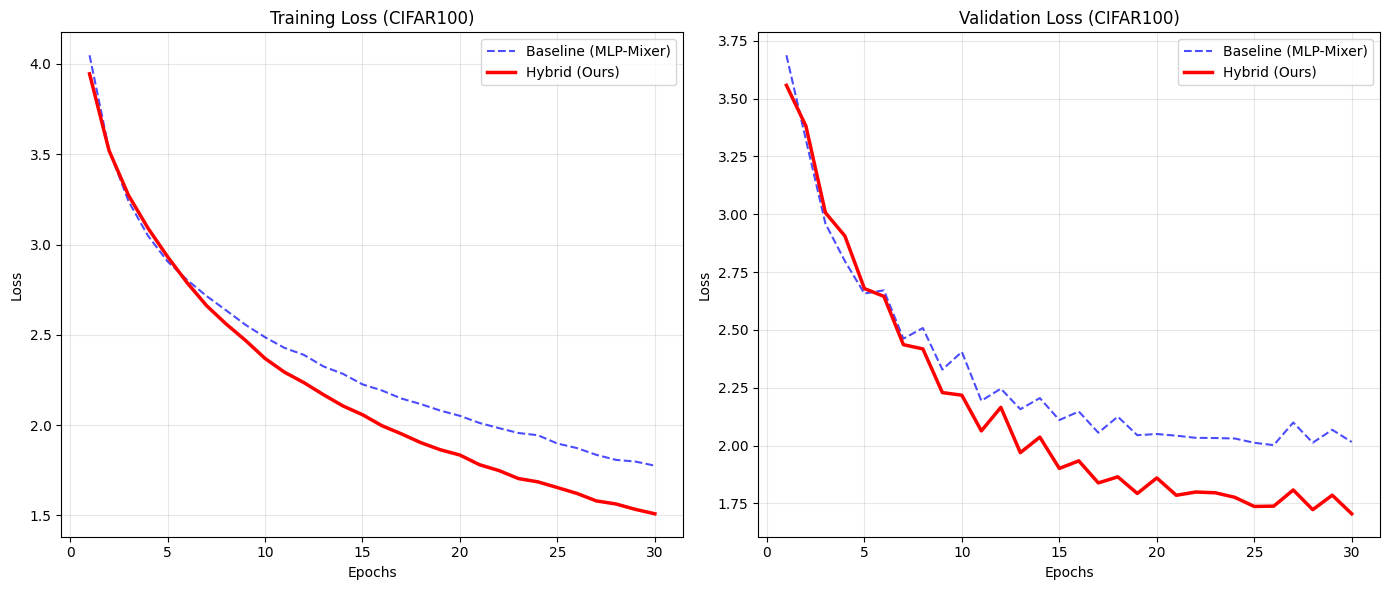

In [ ]:
import json
import matplotlib.pyplot as plt

def plot_loss_curves(history_file='training_history.json', dataset='cifar10'):
    # 1. Load history
    try:
        with open(history_file, 'r') as f:
            data = json.load(f)
        print(f"Loaded {history_file}")
    except FileNotFoundError:
        print("Error: training_history.json not found.")
        return

    baseline_key = f"{dataset}_mlp_mixer"
    hybrid_key = f"{dataset}_hybrid_mixer"

    if baseline_key not in data:
        print(f"Missing data for {baseline_key}")
        return

    baseline = data[baseline_key]
    hybrid = data[hybrid_key]

    epochs = range(1, len(baseline['train_loss']) + 1)

    # Create figure with 2 subplots
    plt.figure(figsize=(14, 6))

    # --- GRAPH 1: Training Loss (Baseline vs Hybrid) ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, baseline['train_loss'], label='Baseline (MLP-Mixer)', linestyle='--', color='blue', alpha=0.7)
    plt.plot(epochs, hybrid['train_loss'], label='Hybrid (Ours)', linewidth=2.5, color='red')

    plt.title(f'Training Loss ({dataset.upper()})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- GRAPH 2: Validation Loss (Baseline vs Hybrid) ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, baseline['val_loss'], label='Baseline (MLP-Mixer)', linestyle='--', color='blue', alpha=0.7)
    plt.plot(epochs, hybrid['val_loss'], label='Hybrid (Ours)', linewidth=2.5, color='red')

    plt.title(f'Validation Loss ({dataset.upper()})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'loss_curves_{dataset}.png', dpi=300)
    print(f"Plot saved to loss_curves_{dataset}.png")
    plt.show()

if __name__ == "__main__":
    plot_loss_curves(dataset='cifar100')

In [ ]:
df = pd.read_csv('results_summary.csv')
df

,model,dataset,best_val_accuracy
0,mlp_mixer,cifar10,76.71
1,hybrid_mixer,cifar10,82.27
2,mlp_mixer,cifar100,48.20
3,hybrid_mixer,cifar100,55.03


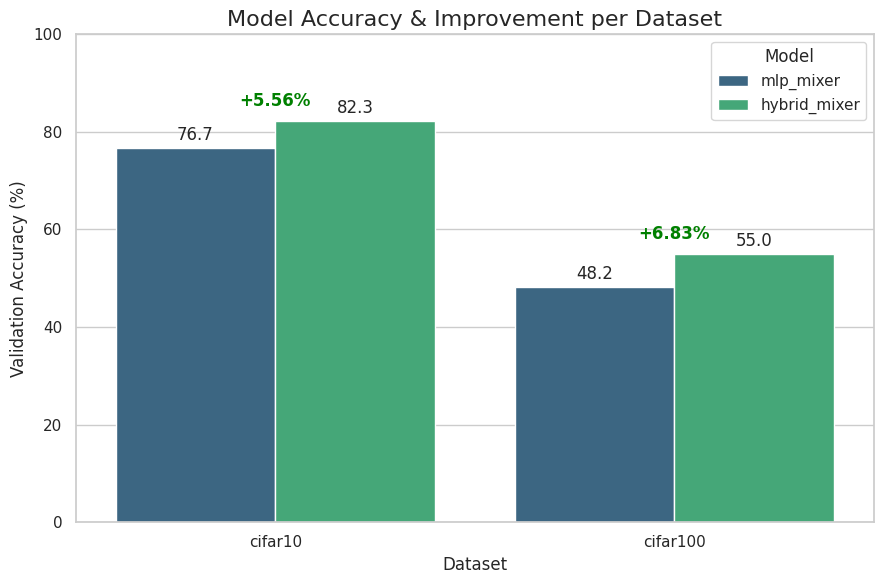

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_pivot = df.pivot(index='dataset', columns='model', values='best_val_accuracy')
# Assuming 'hybrid_mixer' is the improved version:
df_pivot['delta'] = df_pivot['hybrid_mixer'] - df_pivot['mlp_mixer']

# 3. Setup Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 6))

# Define order to ensure consistent subtraction visualization
model_order = ['mlp_mixer', 'hybrid_mixer']

ax = sns.barplot(
    data=df,
    x='dataset',
    y='best_val_accuracy',
    hue='model',
    hue_order=model_order,
    palette='viridis'
)

# 4. Add Bar Labels (Raw Values)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

# 5. Add Delta Annotation (The Improvement)
# We loop through each dataset (0, 1, 2...) on the x-axis
for i, dataset_name in enumerate(df_pivot.index):
    # Get the delta and the max height for this group to place text above it
    delta_val = df_pivot.loc[dataset_name, 'delta']
    max_height = df_pivot.loc[dataset_name, ['mlp_mixer', 'hybrid_mixer']].max()

    # Place text centered at x=i
    plt.text(
        x=i,
        y=max_height + 3,  # Float slightly above the tallest bar
        s=f"+{delta_val:.2f}%",
        ha='center',
        fontsize=12,
        fontweight='bold',
        color='green'
    )

# 6. Final Polish
plt.title('Model Accuracy & Improvement per Dataset', fontsize=16)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.ylim(0, 100) # Ensure room for the labels
plt.legend(title='Model', loc='upper right')

plt.tight_layout()
plt.show()